## Wstępne przetwarzanie danych c.d.

Na danym etapie przeprowadzenie eksploracji danych jest bardzo ciężkim oraz czasochłonnym zadaniem ponieważ zbiór uczący nadal zawiera bardzo dużo kolumn. Więc następnym etapem filtracja cech pod względem właściwości statystycznych.

### Aktualny zakres:
- Transformacja zmiennej celi (do przeniesienia do innego rozdziału)
- Filtracja cech pod względem:
	-  cech stałych
	-  cech quasi-stałych
	-  cech duplikatów
	-  cech o dużej korelacji
- Pierwszy eksperyment uczenia modelu

### Planowane operacje i eksperymenty: 
- Redukcja cech umiejętności (ST, RB, ...) do jednej cechy (np "Skill") za pomocą PCA 
- Przetwarzanie danych odstających
- Normalizacja danych


### Importowanie potrzebnych bibliotek 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

Po poprzedmin przetwarzaniu danych nasz zbiór znajduje się już w nowym pliku

## Wstęp

In [2]:
fifa_data = pd.read_csv('new_data.csv')

In [3]:
cols =  ['Preferred Foot', 'Body Type' , 'Work Rate', 'Position']
fifa_data[cols] = fifa_data[cols].astype('category')

In [4]:
fifa_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16122 entries, 0 to 16121
Data columns (total 66 columns):
Age                16122 non-null int64
Overall            16122 non-null int64
Potential          16122 non-null int64
Preferred Foot     16122 non-null category
Weak Foot          16122 non-null float64
Skill Moves        16122 non-null float64
Work Rate          16122 non-null category
Body Type          16122 non-null category
Position           16122 non-null category
Height             16122 non-null float64
Weight             16122 non-null float64
LS                 16122 non-null int64
ST                 16122 non-null int64
RS                 16122 non-null int64
LW                 16122 non-null int64
LF                 16122 non-null int64
CF                 16122 non-null int64
RF                 16122 non-null int64
RW                 16122 non-null int64
LAM                16122 non-null int64
CAM                16122 non-null int64
RAM                16122 non-nu

In [5]:
fifa_no_category = fifa_data.select_dtypes(exclude=['category'])

### Usuwanie cech stałych

In [6]:
constant_filter = VarianceThreshold(threshold=0)

In [7]:
constant_filter.fit(fifa_no_category)

VarianceThreshold(threshold=0)

In [8]:
selected_features =  fifa_no_category.columns[constant_filter.get_support()]
constant_features = [feature for feature in fifa_no_category if feature not in selected_features]
constant_features

[]

Oryginalny zbiór uczący nie zawiera cech stałych

### Usuwanie quasi-stałych cech

In [9]:
VARIANCE_THRESHHOLD = 0.2
qconstant_filter = VarianceThreshold(threshold=VARIANCE_THRESHHOLD)
qconstant_filter.fit(fifa_no_category)
selected_features =  fifa_no_category.columns[qconstant_filter.get_support()]
qconstant_features = [feature for feature in fifa_no_category if feature not in selected_features]
qconstant_features

[]

Oryginalny zbiór uczący nie zawiera cech quasi-stałych

### Usuwanie Cech duplikatów

In [10]:
def find_duplicate_columns(data):
    no_duplicates_data = data.T.drop_duplicates(keep='first').T
    return [c for c in data.columns if c not in no_duplicates_data.columns]

In [11]:
duplicate_columns = find_duplicate_columns(fifa_data)
duplicate_columns

['ST',
 'RS',
 'CF',
 'RF',
 'RW',
 'CAM',
 'RAM',
 'CM',
 'RCM',
 'RM',
 'CDM',
 'RDM',
 'RWB',
 'CB',
 'RCB',
 'RB']

Widzimy że mamy cechy, które tylko powtażają pewną informacje, któtch nie potrzebujemy mieć w zbiorze uczącym 

In [12]:
fifa_data.drop(columns=duplicate_columns, axis=1, inplace=True)

In [13]:
fifa_data.shape

(16122, 50)

## FILL ME 

In [14]:
fifa_data = fifa_data[fifa_data['Overall'] >=70]
fifa_data.shape

(5137, 50)

The reason of only filtering out 70+ rating players is to see how good players define their position and to find out how to become good player by choosing the right position based on player's attributes.
(translate)

## Label encoding

In [15]:
def encode_labels(col):
    label_encoder = LabelEncoder()
    transform = label_encoder.fit_transform(col)
    print(get_labels_map(label_encoder))
    return transform

def get_labels_map(le):
    return dict(zip(le.classes_, le.transform(le.classes_)))

In [16]:
fifa_categories = fifa_data.select_dtypes('category')

In [17]:
fifa_data[fifa_categories.columns] = fifa_data[fifa_categories.columns].apply(encode_labels)

{'Left': 0, 'Right': 1}
{'High/ High': 0, 'High/ Low': 1, 'High/ Medium': 2, 'Low/ High': 3, 'Low/ Low': 4, 'Low/ Medium': 5, 'Medium/ High': 6, 'Medium/ Low': 7, 'Medium/ Medium': 8}
{'Lean': 0, 'Normal': 1, 'Stocky': 2}
{'CB': 0, 'CF': 1, 'CM': 2, 'LB': 3, 'LF': 4, 'LM': 5, 'RB': 6, 'RF': 7, 'RM': 8, 'ST': 9}


## Eksperyment uczenia modelu

### Train Test Split

In [18]:
fifa_train_data = fifa_data.drop('Position', axis=1)

In [19]:
target = fifa_data['Position']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
        fifa_train_data, target, test_size=0.33, random_state=42)

### Scaling

In [21]:
from sklearn.preprocessing import RobustScaler, StandardScaler

In [22]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled =  scaler.transform(X_test)

### Feature Selection

#### SelectKBest

In [23]:
from sklearn.feature_selection import SelectKBest, f_classif

In [24]:
k_best_selector = SelectKBest(f_classif, k=45)
X_train_scaled_selected = k_best_selector.fit_transform(X_train_scaled, y_train)
X_test_scaled_selected = k_best_selector.transform(X_test_scaled)

#### Rekurencyjna Eliminacja

In [52]:
from sklearn.feature_selection import RFECV

In [70]:
rfecv_selector = RFECV(estimator=RandomForestClassifier(n_estimators=100), cv=5, step=1, n_jobs=4, verbose=5)

In [71]:
X_train_scaled_selected = rfecv_selector.fit_transform(X_train_scaled, y_train)
X_test_scaled_selected = rfecv_selector.transform(X_test_scaled)

Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.


In [72]:
rfecv_selector.n_features_

24

Selected features

In [73]:
[f for f,s in zip(X_train.columns, rfecv_selector.support_) if s]

['Preferred Foot',
 'LAM',
 'LCM',
 'LWB',
 'LCB',
 'Crossing',
 'Finishing',
 'HeadingAccuracy',
 'Volleys',
 'Dribbling',
 'LongPassing',
 'Acceleration',
 'SprintSpeed',
 'Jumping',
 'Stamina',
 'Strength',
 'LongShots',
 'Aggression',
 'Interceptions',
 'Positioning',
 'Vision',
 'Marking',
 'StandingTackle',
 'SlidingTackle']

### Modeling

In [29]:
decision_tree_model = DecisionTreeClassifier()

In [30]:
decision_tree_model.fit(X_train_scaled_selected, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Decision Tree 

In [31]:
pred = decision_tree_model.predict(X_test_scaled_selected)

In [32]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.33      0.33      0.33       132
           1       0.00      0.00      0.00         5
           2       0.41      0.39      0.40       309
           3       0.57      0.58      0.58       238
           4       0.13      0.15      0.14        72
           5       0.24      0.27      0.26       222
           6       0.58      0.52      0.55       228
           7       0.10      0.09      0.10        79
           8       0.29      0.30      0.30       240
           9       0.61      0.61      0.61       171

   micro avg       0.40      0.40      0.40      1696
   macro avg       0.33      0.32      0.33      1696
weighted avg       0.40      0.40      0.40      1696



Na razie model radzi sobie bardzo słabo, co jest dość oczekiwanyn wynikiem. Ale możemy sprawdzić czy da się ten wynik poprawić za pomocą np użyciu bagginge, czyli w tym przypadku algorytm **Lasów Losowych** 

### Random Forest

In [87]:
forest = RandomForestClassifier(n_estimators=100, n_jobs=2)
forest.fit(X_train_scaled_selected, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [85]:
forest_pred = forest.predict(X_test_scaled_selected)

In [86]:
print(classification_report(y_test, forest_pred))

              precision    recall  f1-score   support

           0       0.43      0.48      0.45       132
           1       0.00      0.00      0.00         5
           2       0.49      0.79      0.60       309
           3       0.74      0.66      0.70       238
           4       0.17      0.01      0.03        72
           5       0.27      0.16      0.20       222
           6       0.58      0.69      0.63       228
           7       0.14      0.03      0.04        79
           8       0.35      0.23      0.27       240
           9       0.63      0.92      0.75       171

   micro avg       0.52      0.52      0.52      1696
   macro avg       0.38      0.40      0.37      1696
weighted avg       0.47      0.52      0.47      1696



/home/mikita/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [94]:
forest.feature_importances_

array([0.04059021, 0.03782427, 0.03831272, 0.03906409, 0.03658459,
       0.05299473, 0.0516746 , 0.04965564, 0.03633224, 0.03425955,
       0.04961471, 0.03816637, 0.04220327, 0.036706  , 0.03739025,
       0.03868539, 0.03906267, 0.0352795 , 0.04136935, 0.03745545,
       0.0498975 , 0.03893368, 0.04337782, 0.0545654 ])

### KNN

In [36]:
from sklearn.neighbors import KNeighborsClassifier

In [81]:
scores = []
begin_n = 40
end_n = 60
for n in range(begin_n,end_n): 
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train_scaled_selected, y_train)
    score =  knn.score(X_test_scaled_selected, y_test)
    scores.append(score)

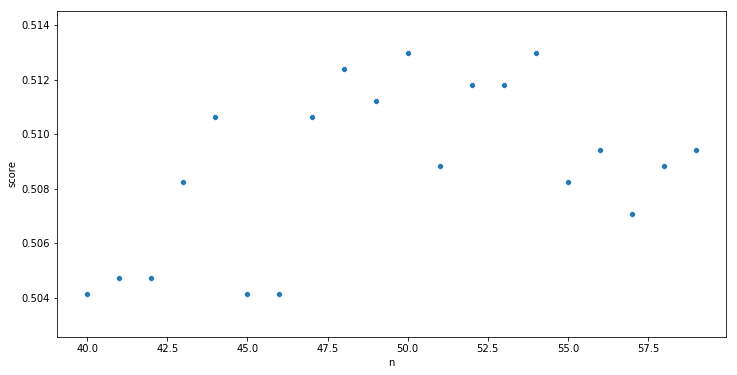

In [82]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='n', y='score',data=pd.DataFrame({'n':list(range(begin_n,end_n)), 'score':scores})) 

### Naive Bayes

In [78]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB

In [79]:
nbg = GaussianNB()
nbb = BernoulliNB()

In [83]:
print('GaussianNB')
print(classification_report(nbg.fit(X_train_scaled_selected, y_train).predict(X_test_scaled_selected), y_test))
print('BernoulliNB')
print(classification_report(nbb.fit(X_train_scaled_selected, y_train).predict(X_test_scaled_selected), y_test))

GaussianNB
              precision    recall  f1-score   support

           0       0.71      0.45      0.55       207
           1       0.00      0.00      0.00        63
           2       0.52      0.43      0.47       379
           3       0.48      0.78      0.60       148
           4       0.24      0.14      0.18       120
           5       0.10      0.28      0.15        81
           6       0.60      0.47      0.52       291
           7       0.34      0.21      0.26       131
           8       0.08      0.26      0.13        76
           9       0.82      0.70      0.75       200

   micro avg       0.43      0.43      0.43      1696
   macro avg       0.39      0.37      0.36      1696
weighted avg       0.50      0.43      0.45      1696

BernoulliNB
              precision    recall  f1-score   support

           0       0.84      0.39      0.53       286
           1       0.00      0.00      0.00        53
           2       0.43      0.41      0.42       324
 